Download attack data from into csv file

In [1]:
from dotenv import load_dotenv
import os
from wandb_download import extract_wandb_runs_to_csv

load_dotenv()  # Load environment variables from .env file
project_name = os.getenv("WANDB_PROJECT")
entity_name = os.getenv("WANDB_ENTITY")
assert project_name, "Please set the WANDB_PROJECT environment variable"
assert entity_name, "Please set the WANDB_ENTITY environment variable"
output_file = "project.csv"

extract_wandb_runs_to_csv(project_name, entity_name, output_file)

In [2]:
import pandas as pd
df = pd.read_csv(output_file)
df.head()

,data_time,coco/bbox_mAP,coco/bbox_mAP_m,coco/bbox_mAP_s,coco/bbox_mAP_50,coco/bbox_mAP_75,time,_step,_runtime,_timestamp,...,train_dataloader.batch_sampler,model.backbone.groups,model.backbone.base_width,visualizer.vis_backends.init_kwargs.config.attack_kwargs.targeted,visualizer.vis_backends.init_kwargs.config.attack_kwargs.random_start,attack_kwargs.targeted,attack_kwargs.random_start,visualizer.vis_backends.init_kwargs.config.attack_kwargs.norm,attack_kwargs.norm,name
0,0.007925,0.288,0.023,0.000,0.520,0.278,0.056036,5.0,379.239436,1.720392e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,free_anchor_convnext-b_voc0712
1,0.013465,0.399,0.435,0.176,0.604,0.417,0.049601,5.0,358.147861,1.720392e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DETR_R-50-FPN
2,0.013553,0.430,0.471,0.238,0.605,0.459,0.097017,5.0,565.258650,1.720392e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SABL Cascade R-CNN_R-101-FPN
3,0.013675,0.451,0.493,0.279,0.629,0.493,0.147559,5.0,875.110591,1.720393e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PAA_R-101-FPN
4,0.013285,0.425,0.465,0.235,0.607,0.464,0.073779,5.0,444.119287,1.720392e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cascade R-CNN_R-101-FPN


Keep interesting columns and observations

In [3]:
df.columns.tolist()

['data_time',
 'coco/bbox_mAP',
 'coco/bbox_mAP_m',
 'coco/bbox_mAP_s',
 'coco/bbox_mAP_50',
 'coco/bbox_mAP_75',
 'time',
 '_step',
 '_runtime',
 '_timestamp',
 'coco/bbox_mAP_l',
 '_wandb.runtime',
 'val_img.path',
 'val_img.size',
 'val_img._type',
 'val_img.width',
 'val_img.format',
 'val_img.height',
 'val_img.sha256',
 'coco/segm_mAP_m',
 'coco/segm_mAP_75',
 'coco/segm_mAP_s',
 'coco/segm_mAP_50',
 'coco/segm_mAP',
 'coco/segm_mAP_l',
 'attack',
 'resume',
 'launcher',
 'work_dir',
 'data_root',
 'load_from',
 'log_level',
 'img_scales',
 'config_file',
 'backend_args',
 'dataset_type',
 'tta_pipeline',
 'vis_backends',
 'default_scope',
 'test_pipeline',
 'train_pipeline',
 'checkpoint_file',
 'param_scheduler',
 'model.neck.type',
 'model.neck.num_outs',
 'model.neck.in_channels',
 'model.neck.start_level',
 'model.neck.out_channels',
 'model.neck.add_extra_convs',
 'model.type',
 'model.backbone.arch',
 'model.backbone.type',
 'model.backbone.with_cp',
 'model.backbone.init_

In [20]:
df.to_csv("project_filtered.csv", index=False)

/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/pfs/work7/workspace/scratch/ma_jjakubas-team_project_fss2024/miniconda3/envs/benchmark/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future vers

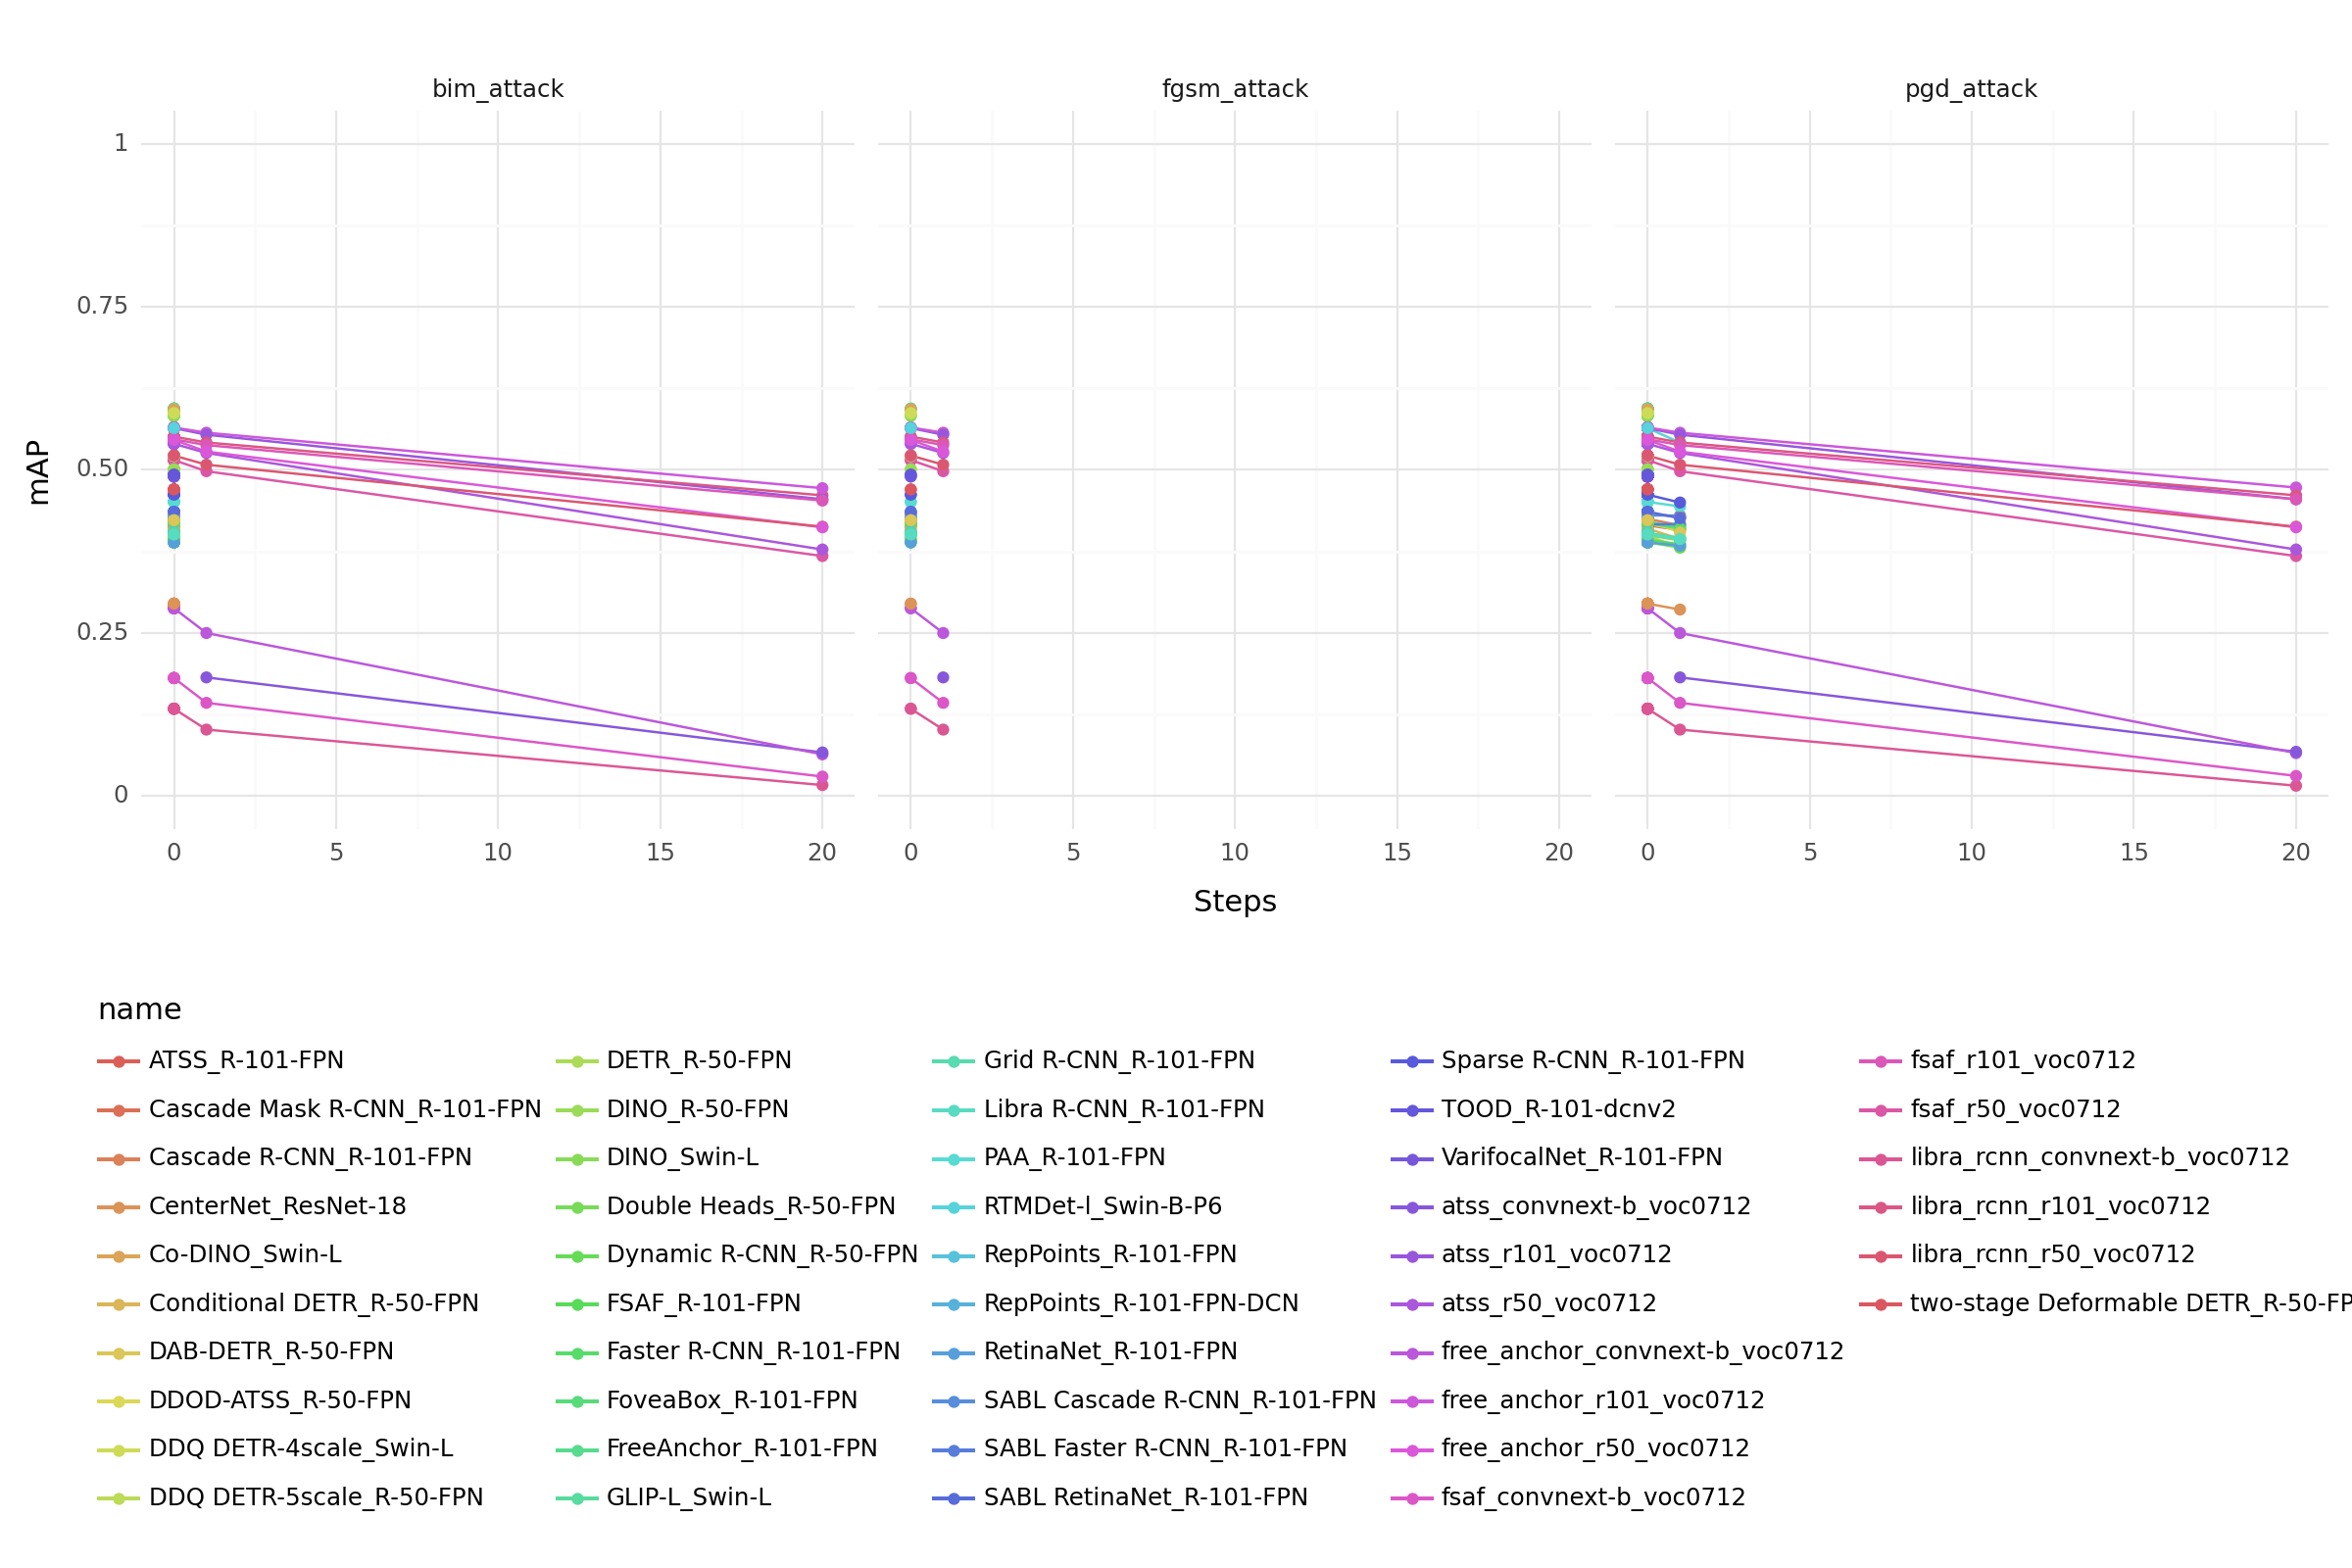

<Figure Size: (1200 x 800)>

In [30]:
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal, facet_wrap, scale_y_continuous, theme

# Preprocess the DataFrame
df = df.filter(regex="attack|^name$|mAP|State")
df = df[df["coco/bbox_mAP"].notna()]

# treat none attack as zeroth step of each attack
no_attacks_df = df[df["attack"] == "none"].copy()
pgd_df = no_attacks_df.copy()
pgd_df["attack"] = "pgd_attack"

bim_df = no_attacks_df.copy()
bim_df["attack"] = "bim_attack"

df.loc[df["attack"] == "fgsm_attack", 'attack_kwargs.steps'] = 1
fgsm_df = no_attacks_df.copy()
fgsm_df["attack"] = "fgsm_attack"

df = pd.concat([df, pgd_df, bim_df, fgsm_df], ignore_index=True)

# Only keep the relevant columns and drop rows with NaN values
df_filtered = df[['coco/bbox_mAP', 'attack_kwargs.steps', 'name', 'attack']].dropna()
df_filtered = df_filtered[df_filtered['attack'] != 'none']

plot = (ggplot(df_filtered, aes(x='attack_kwargs.steps', y='coco/bbox_mAP', color='name'))
        + geom_line()
        + geom_point()
        + labs(x='Steps',
               y='mAP')
        + theme_minimal()
        + facet_wrap('~attack')
        + scale_y_continuous(limits=(0, 1))
        + theme(figure_size=(12, 8),
                legend_position='bottom'))  # Set legend position to bottom

plot

In [27]:
df["attack"].unique()

array(['none', 'pgd_attack', 'bim_attack', 'fgsm_attack'], dtype=object)